In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
df = pd.read_csv('goldstock.csv')#importing-dataset

In [3]:
df.isna().sum() #checking missing values in our dataset

Unnamed: 0    0
Date          0
Close         0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [3]:
df.head() #taking overview of dataset

,Unnamed: 0,Date,Close,Volume,Open,High,Low
0,0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


In [4]:
df.drop(columns=['Unnamed: 0'],inplace=True)
df.head()

,Date,Close,Volume,Open,High,Low
0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


Checking for multicolinearity

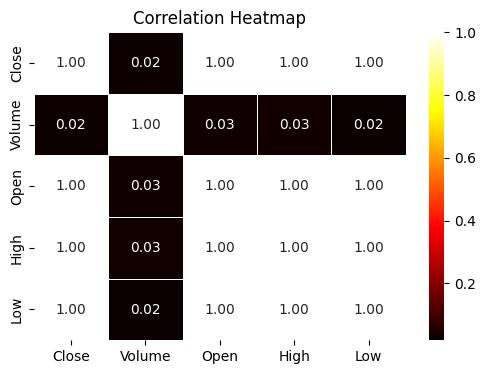

In [8]:
# Selecting only numerical columns
numeric_columns = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot the correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='hot', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
Converting our data into time series data

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df.set_index('Date', inplace=True) #setting date as index to attach each and every feature with time

KeyError: "None of ['Date'] are in the columns"

In [22]:
# Ensure the dataset is sorted by date
df.sort_index(inplace=True)

In [32]:
df.head(5)

,Close,Volume,Open,High,Low,Stationary_Close
Date,,,,,,
2014-01-22,1238.6,80262.0,1240.5,1243.5,1235.5,NaN
2014-01-23,1262.5,41697.0,1235.1,1267.1,1230.8,23.9
2014-01-24,1264.5,34998.0,1264.3,1273.2,1256.9,2.0
2014-01-27,1263.5,63419.0,1269.9,1280.1,1252.0,-1.0
2014-01-28,1250.5,81426.0,1254.9,1261.9,1248.0,-13.0


In [24]:
df.columns

Index(['Close', 'Volume', 'Open', 'High', 'Low'], dtype='object')

 Visualization of the Time Series

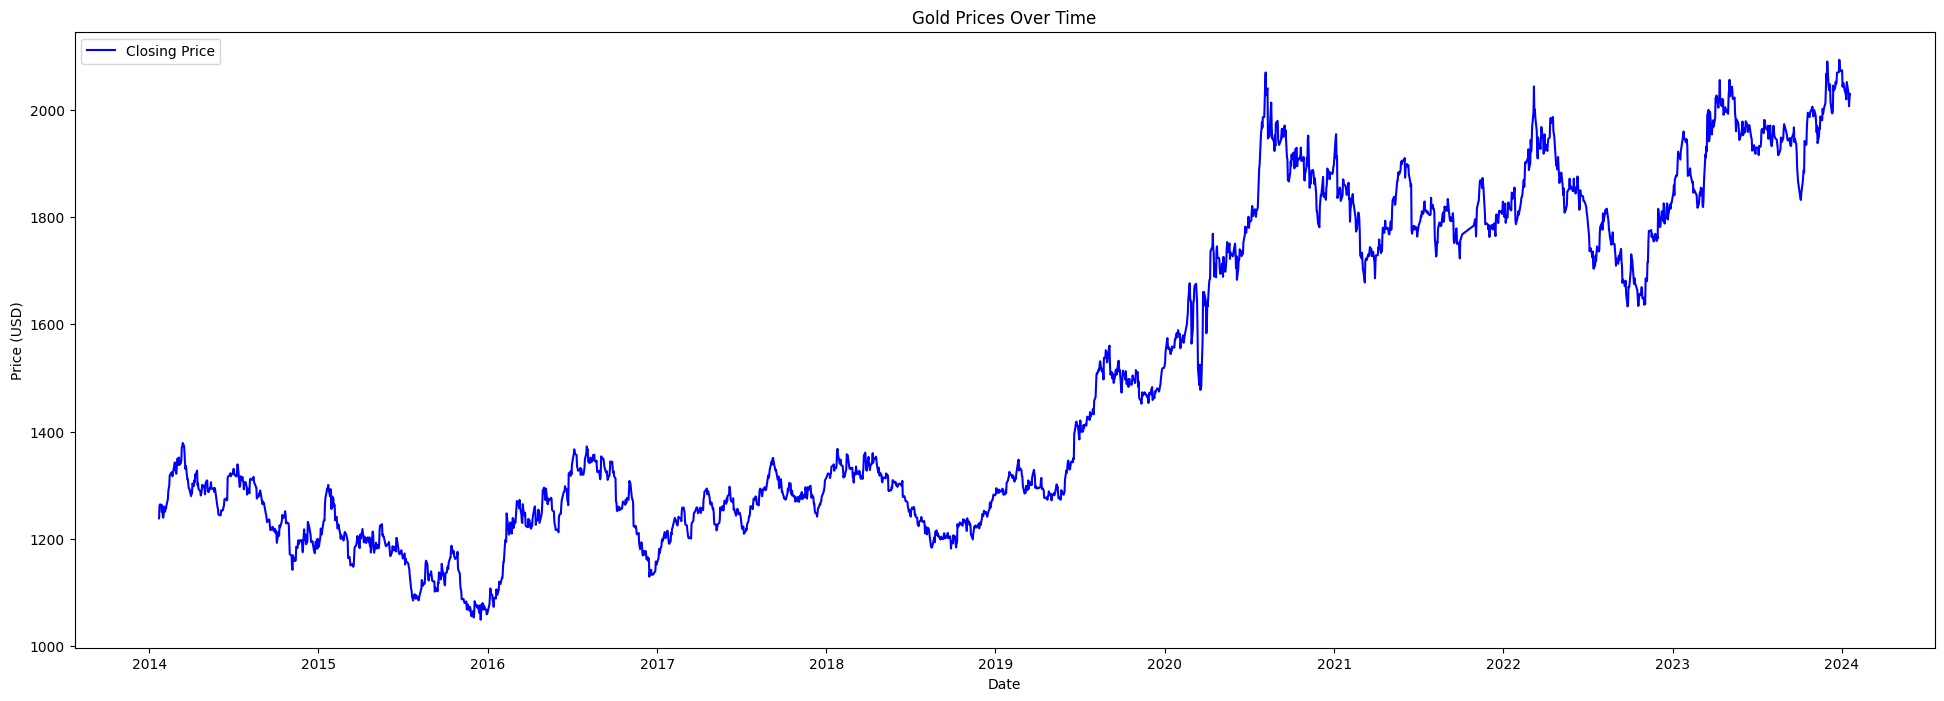

In [26]:
plt.figure(figsize=(24, 8))
plt.plot(df['Close'], label='Closing Price', color='blue')
plt.title('Gold Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [25]:
# Decompose the time series into trend, seasonality, and residuals
decomposition = seasonal_decompose(df['Close'], model='additive', period=365) 

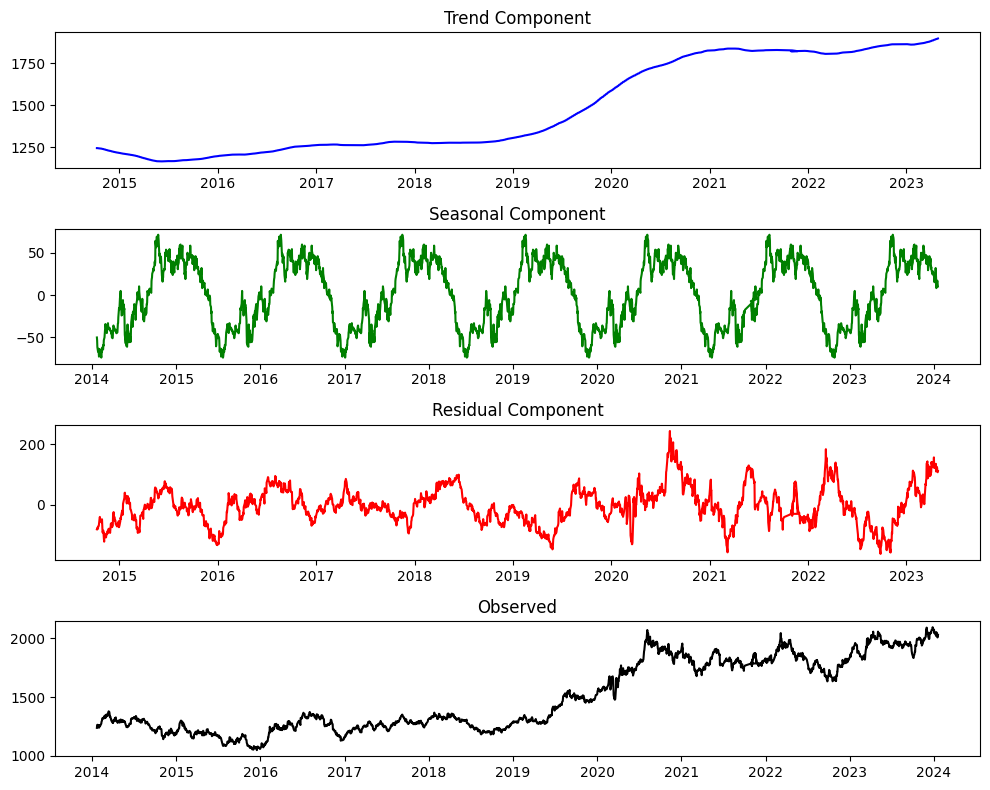

In [19]:
plt.figure(figsize=(10, 8)) #visualisation of trends
plt.subplot(411)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.title('Trend Component')
plt.subplot(412)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.subplot(413)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.title('Residual Component')
plt.subplot(414)
plt.plot(decomposition.observed, label='Observed', color='black')
plt.title('Observed')
plt.tight_layout()
plt.show()


Checking for stationarity data

In [21]:
result = adfuller(df['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.717275578970478
p-value: 0.4222342775667282
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


As p value not is smaller than significance level so we failed to reject null hypothesis of data is not stationary

In [27]:
# Example: Differencing for stationarity
df['Stationary_Close'] = df['Close'] - df['Close'].shift(1)

Making our data stationary

In [29]:
result = adfuller(df['Stationary_Close'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.991329064386258
p-value: 1.9925373418771825e-17
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


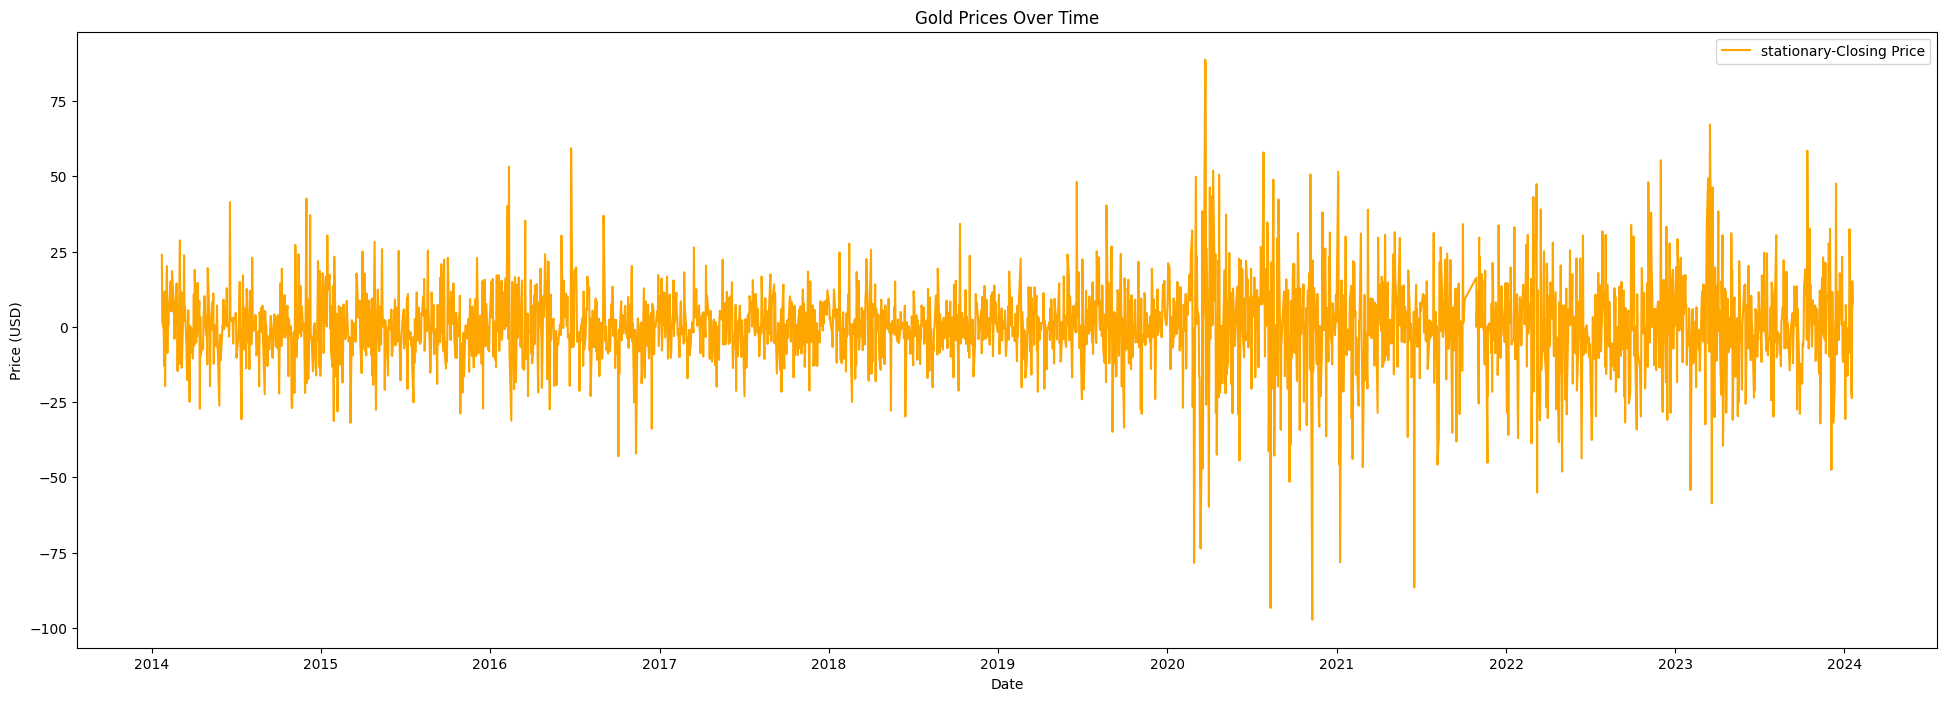

In [30]:
#visualizing  
plt.figure(figsize=(24, 8))
plt.plot(df['Stationary_Close'], label='stationary-Closing Price', color='orange')
plt.title('Gold Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

Dealing with seasonality

<Figure size 5000x400 with 0 Axes>

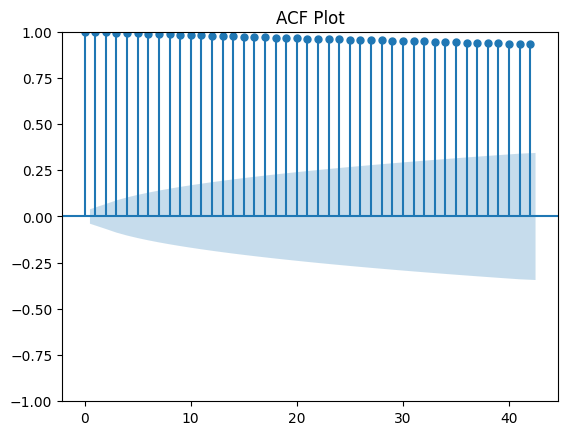

In [45]:
plt.figure(figsize=(50, 4))
plot_acf(df['Close'], lags=42, title='ACF Plot')
plt.show()

C:\Users\omshr\AppData\Local\Temp\ipykernel_2640\3675127034.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / frequencies, spectrum)


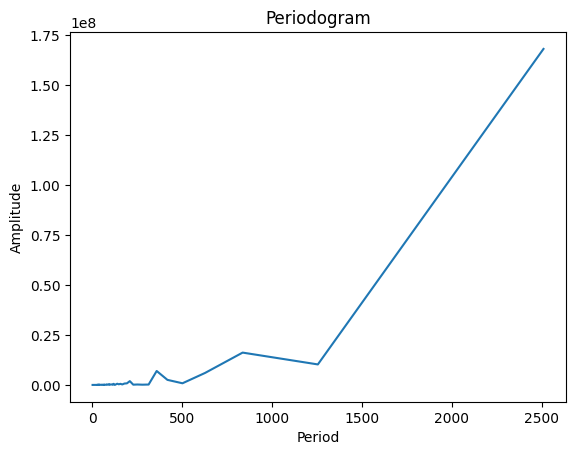

In [46]:
from scipy.signal import periodogram

frequencies, spectrum = periodogram(df['Close'])
plt.plot(1 / frequencies, spectrum)
plt.title('Periodogram')
plt.xlabel('Period')
plt.ylabel('Amplitude')
plt.show()

Building model for forecasting

In [51]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['Close'], order=(5,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)  # Forecasting the next 30 days
pd.DataFrame(forecast).reset_index().drop(columns=['index'])


C:\Users\omshr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\omshr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\omshr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\omshr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is ava

,predicted_mean
0,2028.675090
1,2029.971834
2,2029.861645
3,2029.525464
4,2029.550855
5,2029.512959
6,2029.499338
7,2029.511302
8,2029.510983
9,2029.511503


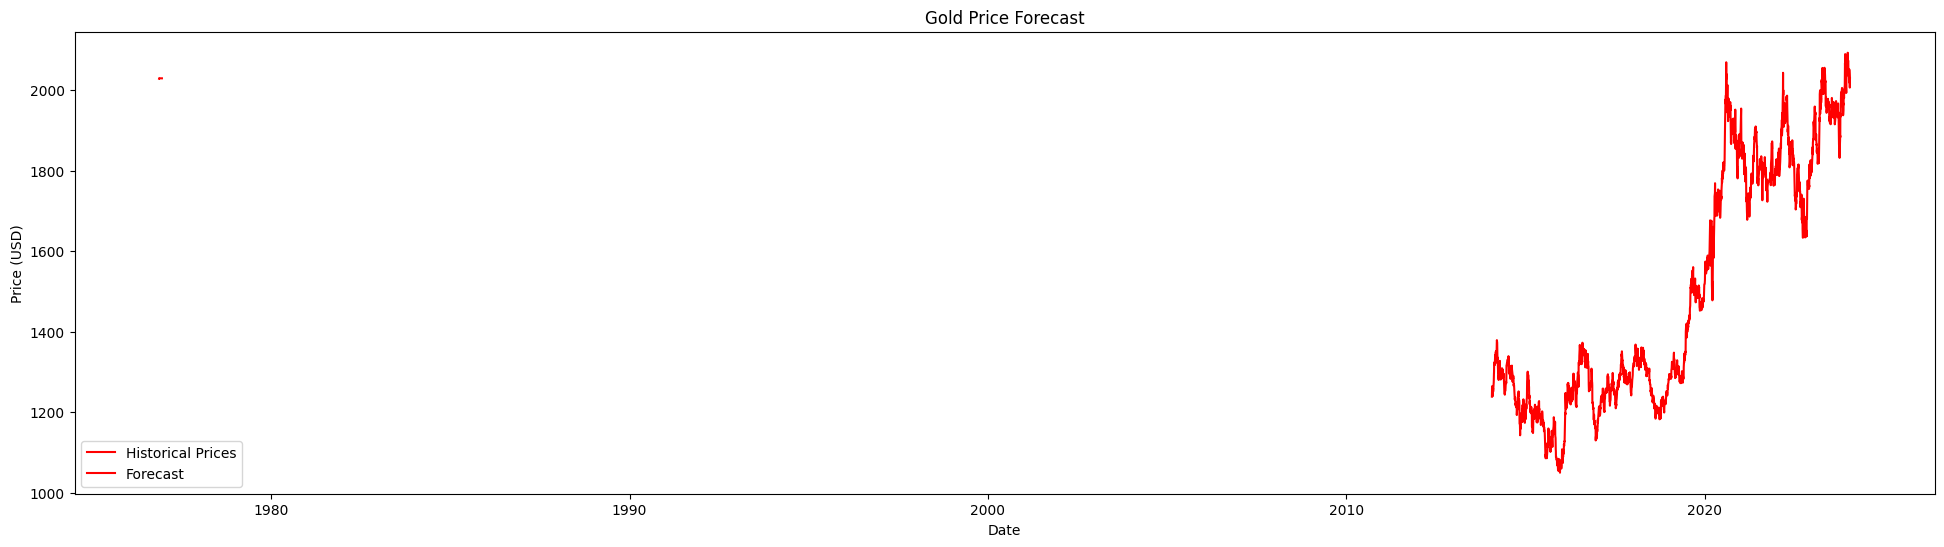

In [52]:
plt.figure(figsize=(24, 6))
plt.plot(df['Close'], label='Historical Prices', color='red')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Gold Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Generate random test data for demonstration
np.random.seed(0)
test_actual = np.random.rand(30)  # Assuming 30 days of test data

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_actual, forecast)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_actual, forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)


Mean Absolute Error (MAE): 2028.9313357937513
Mean Squared Error (MSE): 4116562.4723238875
Root Mean Squared Error (RMSE): 2028.9313621519796


             Close  Signal   Returns    Profit  Cumulative_Profit
Date                                                             
2014-01-22  1238.6      -1       NaN       NaN                NaN
2014-01-23  1262.5      -1  0.019296 -0.019296          -0.019296
2014-01-24  1264.5      -1  0.001584 -0.001584          -0.020880
2014-01-27  1263.5       1 -0.000791 -0.000791          -0.021671
2014-01-28  1250.5       1 -0.010289 -0.010289          -0.031960
...            ...     ...       ...       ...                ...
2024-01-12  2051.6      -1  0.016046 -0.016046         -16.518923
2024-01-16  2030.2       1 -0.010431 -0.010431         -16.529354
2024-01-17  2006.5       1 -0.011674 -0.011674         -16.541028
2024-01-18  2021.6      -1  0.007526 -0.007526         -16.548554
2024-01-19  2029.3      -1  0.003809 -0.003809         -16.552362

[2511 rows x 5 columns]


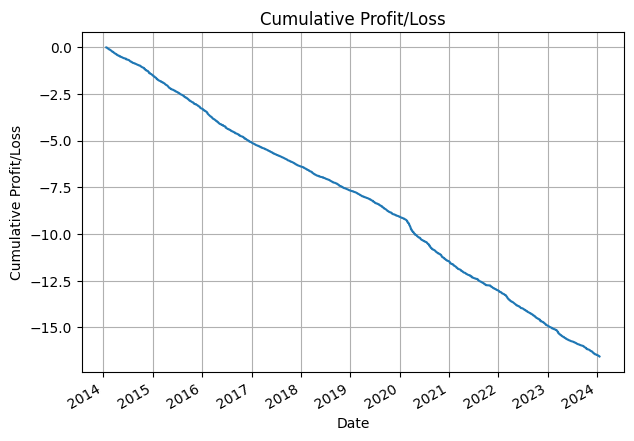

In [59]:
# Assuming df is your DataFrame containing the price and volume information

# Calculate daily returns
df['Returns'] = df['Close'].pct_change()

# Define the trading signal
# For a reverse trading strategy, we'll buy (1) when the previous day's return is negative and sell (-1) otherwise
df['Signal'] = df['Returns'].apply(lambda x: 1 if x < 0 else -1)

# Calculate daily profit/loss
df['Profit'] = df['Signal'] * df['Returns']

# Calculate cumulative profit/loss
df['Cumulative_Profit'] = df['Profit'].cumsum()

# Backtesting results
print(df[['Close', 'Signal', 'Returns', 'Profit', 'Cumulative_Profit']])

# Visualize cumulative profit/loss
df['Cumulative_Profit'].plot(figsize=(7, 5), title='Cumulative Profit/Loss')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit/Loss')
plt.grid(True)
plt.show()
